In [2]:
!pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken opencv-python

In [3]:
!pip install langchain-community

In [4]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [5]:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')

In [6]:
output_path = "./images"

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import nltk

nltk.download('gutenberg')

emma = nltk.corpus.gutenberg.words('austen-emma.txt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [9]:
pip install --upgrade nltk

In [10]:

import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (155 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123801 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [13]:
# Extract elements from a PDF and save images
output_path = "./images"  # Directory where extracted images will be saved
raw_pdf_elements = partition_pdf(
    filename="/content/NIPS-2017-attention-is-all-you-need-Paper.pdf",  # Path to the input PDF file
    extract_images_in_pdf=True,  # Enable extraction of images from the PDF
    infer_table_structure=True,  # Enable table structure extraction from the PDF
    chunking_strategy="by_title",  # Split the document into chunks based on titles/headings
    max_characters=4000,  # Maximum number of characters allowed in each text chunk
    new_after_n_chars=3800,  # Start a new chunk after 3800 characters to avoid splitting in the middle of a section
    combine_text_under_n_chars=2000,  # Combine smaller text blocks that are less than 2000 characters
    extract_image_block_output_dir=output_path,  # Directory to save extracted images from the PDF
)


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# Initialize lists to hold text and table elements
text_elements = []  # List to store extracted text elements
table_elements = []  # List to store extracted table elements

# Initialize lists to hold summaries of text and tables
text_summaries = []  # List to store summaries of text elements
table_summaries = []  # List to store summaries of table elements

# Define a prompt template for summarization
summary_prompt = """
Summarize the following {element_type}:
{element}
"""

# Create an LLMChain to generate summaries using the OpenAI model
summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key, max_tokens=1024),  # Use GPT-3.5-turbo model
    prompt=PromptTemplate.from_template(summary_prompt)  # Use the defined prompt template for summarization
)

# Loop through the raw PDF elements to extract and summarize text and tables
for e in raw_pdf_elements:
    # Check if the element is a text element
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)  # Add the text to the list
        summary = summary_chain.run({'element_type': 'text', 'element': e})  # Generate a summary for the text
        text_summaries.append(summary)  # Store the summary

    # Check if the element is a table
    elif 'Table' in repr(e):
        table_elements.append(e.text)  # Add the table to the list
        summary = summary_chain.run({'element_type': 'table', 'element': e})  # Generate a summary for the table
        table_summaries.append(summary)  # Store the summary


<ipython-input-14-313600dbc14e>:17: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key, max_tokens=1024),  # Use GPT-3.5-turbo model
<ipython-input-14-313600dbc14e>:16: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  summary_chain = LLMChain(
<ipython-input-14-313600dbc14e>:26: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = summary_chain.run({'element_type': 'text', 'element': e})  # Generate a 

In [15]:
# Initialize lists to hold image elements and their summaries
image_elements = []  # List to store base64 encoded image elements
image_summaries = []  # List to store summaries of images

# Function to encode an image file to base64
def encode_image(image_path):
    with open(image_path, "rb") as f:  # Open the image file in binary mode
        return base64.b64encode(f.read()).decode('utf-8')  # Encode the image to base64 and decode to UTF-8 string

# Function to summarize an image given its encoded base64 string
def summarize_image(encoded_image):
    # Define the prompt for the image summarization
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images from the research paper."),
        HumanMessage(content=[  # Create a human message with image description request
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",  # Include the encoded image in the prompt
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    # Generate the response from the model using the prompt
    response = ChatOpenAI(model="gpt-4-turbo", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content  # Return the model's response content

# Loop through the output directory to process each image file
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
        image_path = os.path.join(output_path, i)  # Construct the full path to the image
        encoded_image = encode_image(image_path)  # Encode the image to base64
        image_elements.append(encoded_image)  # Store the encoded image
        summary = summarize_image(encoded_image)  # Summarize the image content
        image_summaries.append(summary)  # Store the image summary


In [16]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 23.3 MB/s eta 0:00:00


In [17]:
# Create lists to hold Document objects and retrieval contents
documents = []  # List to store Document objects for vector store
retrieve_contents = []  # List to store original content with their IDs for retrieval

# Loop through extracted text elements and their summaries to create Document objects
for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())  # Generate a unique ID for each document
    doc = Document(  # Create a Document object for text
        page_content=s,  # Use the summarized text as the page content
        metadata={  # Store metadata for the document
            'id': i,  # Unique ID
            'type': 'text',  # Document type
            'original_content': e  # Original text content
        }
    )
    retrieve_contents.append((i, e))  # Append the ID and original content to retrieval list
    documents.append(doc)  # Add the Document object to the documents list

# Loop through extracted table elements and their summaries to create Document objects
for e, s in zip(table_elements, table_summaries):
    doc = Document(  # Create a Document object for table
        page_content=s,  # Use the summarized table as the page content
        metadata={  # Store metadata for the document
            'id': i,  # Unique ID (use the same ID for each document in the loop)
            'type': 'table',  # Document type
            'original_content': e  # Original table content
        }
    )
    retrieve_contents.append((i, e))  # Append the ID and original content to retrieval list
    documents.append(doc)  # Add the Document object to the documents list

# Loop through extracted image elements and their summaries to create Document objects
for e, s in zip(image_elements, image_summaries):
    doc = Document(  # Create a Document object for image
        page_content=s,  # Use the summarized image as the page content
        metadata={  # Store metadata for the document
            'id': i,  # Unique ID (use the same ID for each document in the loop)
            'type': 'image',  # Document type
            'original_content': e  # Original image content
        }
    )
    retrieve_contents.append((i, s))  # Append the ID and summary to retrieval list
    documents.append(doc)  # Add the Document object to the documents list

# Create a FAISS vector store from the Document objects using OpenAI embeddings for retrieval
vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))


<ipython-input-17-4f7134fb1398>:46: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))


In [18]:
vectorstore.save_local("faiss_index")

In [19]:
prompt_template = """
You are a expert in analyzing the research paper.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [20]:
qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-4", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [21]:
def answer(question):
    relevant_docs = vectorstore.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    # print(relevant_docs)
    return result, relevant_images


In [22]:
# result, relevant_images = answer("What is Transformer?")
# print(result)

Multi-Head Attention is a mechanism used in machine learning models, specifically in the Transformer architecture. This mechanism extends the scaled dot-product attention by parallelizing the attention process across multiple "heads". 

In this method, instead of performing a single attention function with dmodel-dimensional keys, values, and queries, it is found beneficial to linearly project the queries, keys, and values h times with different, learned linear projections to dk, dk, and dv dimensions, respectively. Then, the attention function is performed on each of these projected versions of queries, keys, and values in parallel, yielding dv-dimensional output values. 

These output values are then concatenated and once again projected, resulting in the final values. This allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this. 

In the specific work referenced, there are

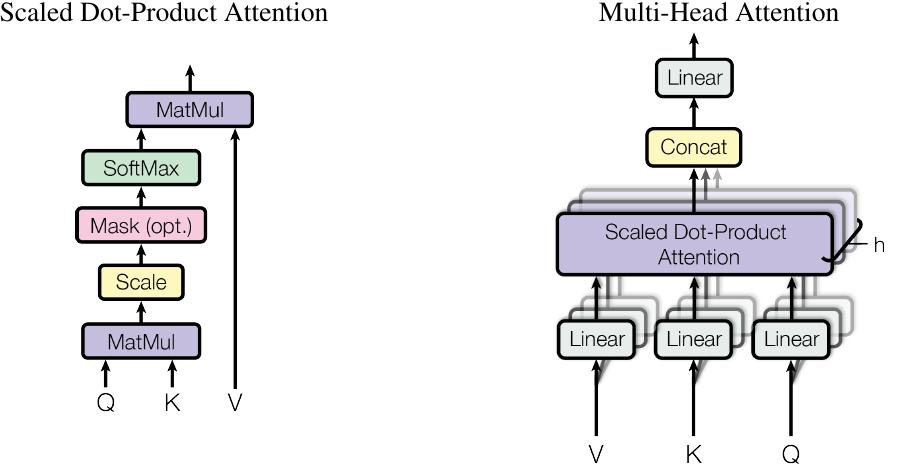

In [29]:
result, relevant_images = answer("multi head attention?")
print(result)

if relevant_images: # Check if the list is not empty before accessing elements
    display.display(display.Image(base64.b64decode(relevant_images[0])))
else:
    print("No relevant images found.")